### **This is a Colab notebook used for classification of electron micrograph images.** Last updated May 11, 2020.
Future directions:


*   Compare CPU/GPU/TPU computation
*   Play with data augmentation (achieve 90% accuracy over 5 classes!)
*   Way to view specific images that were mis-classified
*   New model geometries (try fine tuning instead of full model fitting!)
*   Saliency maps/interpretability
*   Web portal to upload images








In [0]:
!kill -9 -1 #IF GPU NOT WORKING - However, only had to use this one time...
#Somehow it seems the first GPU run of the day may take a while (i.e. 1000s) but after that it may only take 40 s per epoch

In [16]:
from google.colab import drive #mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#import tensorflow 2.2.0, and check that you have a GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.2.0-rc4


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#sklearn imports for confusion matrix and data analysis, not machine learning itself
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#add data locations
train_dir = './drive/My Drive/SupportClassification/POFTiO2Al2O3SiO2/train'
validation_dir = './drive/My Drive/SupportClassification/POFTiO2Al2O3SiO2/validation'

train_Al2O3_dir = os.path.join(train_dir, 'Al2O3')
train_TiO2_dir = os.path.join(train_dir, 'TiO2')
train_SiO2NBs_dir = os.path.join(train_dir, 'SiO2NBs')
train_POF_dir = os.path.join(train_dir, 'POF')
train_NPs_dir = os.path.join(train_dir, 'NPs')


validation_Al2O3_dir = os.path.join(validation_dir, 'Al2O3')
validation_TiO2_dir = os.path.join(validation_dir, 'TiO2')
validation_SiO2NBs_dir = os.path.join(validation_dir, 'SiO2NBs')
validation_POF_dir = os.path.join(validation_dir, 'POF')
validation_NPs_dir = os.path.join(validation_dir, 'NPs')



In [0]:
num_Al2O3_tr = len(os.listdir(train_Al2O3_dir))
num_TiO2_tr = len(os.listdir(train_TiO2_dir))
num_SiO2NBs_tr = len(os.listdir(train_SiO2NBs_dir))
num_POF_tr = len(os.listdir(train_POF_dir))
num_NPs_tr = len(os.listdir(train_NPs_dir))

num_Al2O3_val = len(os.listdir(validation_Al2O3_dir))
num_TiO2_val = len(os.listdir(validation_TiO2_dir))
num_SiO2NBs_val = len(os.listdir(validation_SiO2NBs_dir))
num_POF_val = len(os.listdir(validation_POF_dir))
num_NPs_val = len(os.listdir(validation_NPs_dir))

total_train = num_Al2O3_tr + num_TiO2_tr + num_SiO2NBs_tr + num_POF_tr + num_NPs_tr
total_val = num_Al2O3_val + num_TiO2_val + num_SiO2NBs_val + num_POF_val + num_NPs_val

In [21]:
print('total training Al2O3 images:', num_Al2O3_tr)
print('total training TiO2 images:', num_TiO2_tr)
print('total training SiO2NBs images:', num_SiO2NBs_tr)
print('total training POF images:', num_POF_tr)
print('total training NPs images:', num_NPs_tr)

print('total validation Al2O3 images:', num_Al2O3_val)
print('total validation TiO2 images:', num_TiO2_val)
print('total validation SiO2NBs images:', num_SiO2NBs_val)
print('total validation POF images:', num_POF_val)
print('total validation NPs images:', num_NPs_val)

print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
#would be nice to have a bar/pie graph of this information

total training Al2O3 images: 844
total training TiO2 images: 599
total training SiO2NBs images: 423
total training POF images: 982
total training NPs images: 1461
total validation Al2O3 images: 314
total validation TiO2 images: 200
total validation SiO2NBs images: 130
total validation POF images: 327
total validation NPs images: 241
--
Total training images: 4309
Total validation images: 1212


In [0]:
batch_size = 128
epochs = 60
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [0]:
#top used for if you want to do data augmentation
'''train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
'''
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [24]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 4304 images belonging to 5 classes.


In [25]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              shuffle = False)

Found 1210 images belonging to 5 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

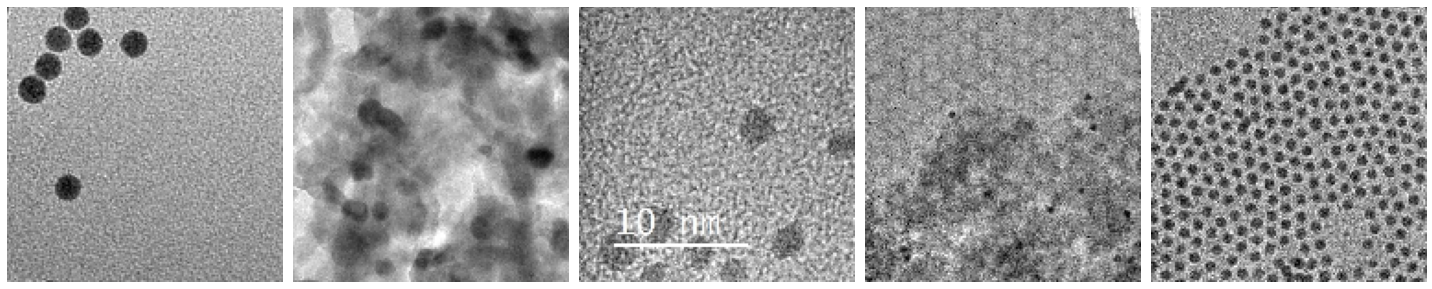

In [29]:
plotImages(sample_training_images[15:20]) #somehow this only goes up to 128 images

In [0]:
#Here is where you can change all the model hyperparameters you want!
model = Sequential([
    Conv2D(16, 3, padding='valid', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(16, 3, padding='valid', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.25), #rate is .45, implies dropouts out neuron 45% of the time,
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25), #rate is .45, implies dropouts out neuron 45% of the time,
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='valid', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25), #rate is .45, implies dropouts out neuron 45% of the time,
    Conv2D(128, 3, padding='valid', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='valid', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.25), #rate is .45, implies dropouts out neuron 45% of the time,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(5, activation = "softmax")
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy (),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 73, 73, 32)        4640      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 32)       

In [38]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/60
33/33 [==============================] - 1149s 35s/step - loss: 1.5529 - accuracy: 0.2941 - val_loss: 1.5483 - val_accuracy: 0.2092
Epoch 2/60
33/33 [==============================] - 45s 1s/step - loss: 1.3183 - accuracy: 0.4090 - val_loss: 1.3590 - val_accuracy: 0.4167
Epoch 3/60
33/33 [==============================] - 44s 1s/step - loss: 1.1065 - accuracy: 0.5199 - val_loss: 1.1342 - val_accuracy: 0.4748
Epoch 4/60
33/33 [==============================] - 45s 1s/step - loss: 1.0394 - accuracy: 0.5608 - val_loss: 1.1031 - val_accuracy: 0.4653
Epoch 5/60
33/33 [==============================] - 44s 1s/step - loss: 1.0051 - accuracy: 0.5738 - val_loss: 1.1590 - val_accuracy: 0.4384
Epoch 6/60
33/33 [==============================] - 45s 1s/step - loss: 0.9235 - accuracy: 0.5975 - val_loss: 1.0012 - val_accuracy: 0.5582
Epoch 7/60
33/33 [==============================] - 45s 1s/step - loss: 0.9198 - accuracy: 0.6097 - val_loss: 1.1566 - val_accuracy: 0.4288
Epoch 8/60
33/33 

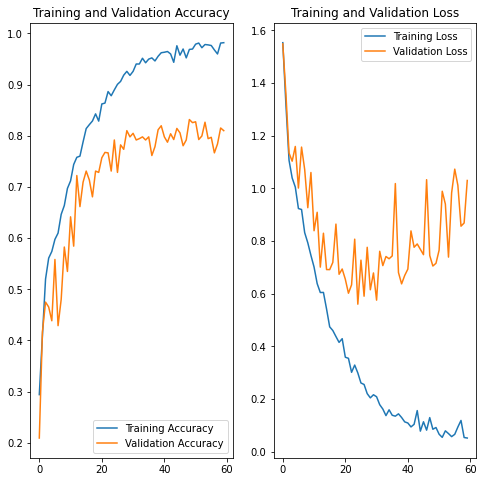

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(val_data_gen, 1208 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf_mat = confusion_matrix(val_data_gen.classes, y_pred)
print(conf_mat)
print('Classification Report')
target_names = ['Al2O3', 'NPs', 'POF', 'SiO2', 'TiO2']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[209   5  28   4  68]
 [  2 225   9   4   1]
 [ 49  11 257   4   6]
 [  1   0   0 123   5]
 [ 19   1   5   2 172]]
Classification Report
              precision    recall  f1-score   support

       Al2O3       0.75      0.67      0.70       314
         NPs       0.93      0.93      0.93       241
         POF       0.86      0.79      0.82       327
        SiO2       0.90      0.95      0.92       129
        TiO2       0.68      0.86      0.76       199

    accuracy                           0.81      1210
   macro avg       0.82      0.84      0.83      1210
weighted avg       0.82      0.81      0.81      1210



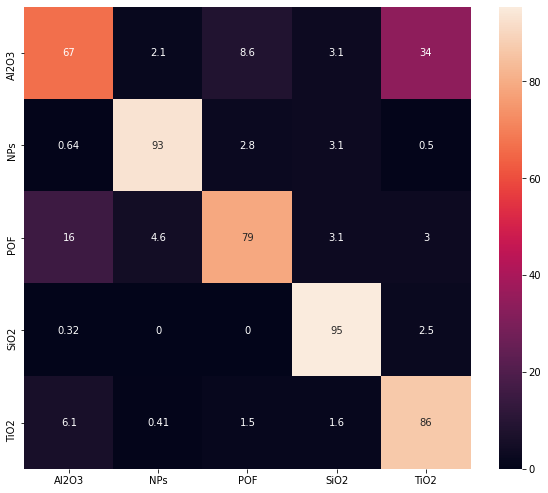

In [41]:
target_names = ['Al2O3', 'NPs', 'POF', 'SiO2', 'TiO2']
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1) * 100
df_cm = pd.DataFrame(conf_mat, index = [i for i in target_names],
                  columns = [i for i in target_names])
fig = plt.figure(figsize = (10,8.5))
#plt.xlabel('ylabel', fontsize=18)
sn.heatmap(df_cm, annot=True)

Model accuracy is 0.8152777671813964


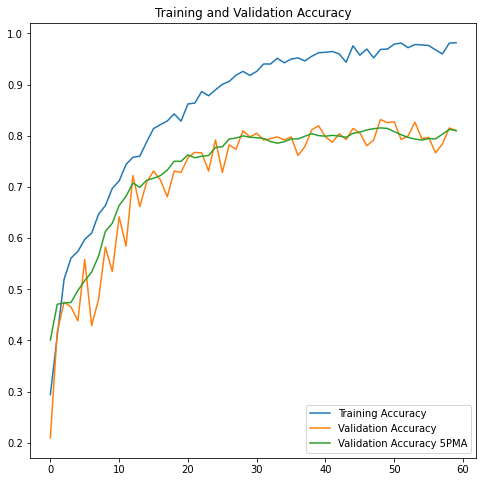

In [43]:
#For now, we will use this to describe a model accuracy
#Take 5-period moving average of validation accuracy, and take the maximum
val5 = []
for i in range(len(val_acc)):
  mov_av = np.mean(val_acc[i:   min(i+5, len(val_acc))   ])
  val5.append(mov_av)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, val5, label='Validation Accuracy 5PMA')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

best_accuracy = np.max(val5)
print('Model accuracy is {}'.format(best_accuracy))
  
